# Pair Programming Normalización

In [30]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Gráficos
# ------------------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Transformación de los datos
# ------------------------------------------------------------------------------
from scipy import stats
import math 
from sklearn.preprocessing import MinMaxScaler

# Para la gestión de los warning
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

# Para poder ver todas las columnas del dataframe
# ------------------------------------------------------------------------------
pd.options.display.max_columns = None 

En este ejercicio de pair programming seguiréis usando el dataset que seleccionasteis.

Sobre la variable respuesta, en pair programmings anterior identificastéis si seguía una distribución normal o no. En caso de que no siguiera una distribución normal, normalizarla. Podéis usar el método que prefiráis o el que mejor se ajuste.

Guardar en un csv el nuevo dataframe que habéis creado para seguir usándolo en los siguientes pair programmings

In [31]:
df= pd.read_csv('data/sin_outliers_data.csv', index_col=0)

Hacemos reset_index para que elimine los indices y no se generen nulos después, cuando unimos las columnas resultantes de sklearn.

In [32]:
df.reset_index(inplace=True)

In [33]:
df.drop('index', inplace=True, axis=1)

In [34]:
df.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523


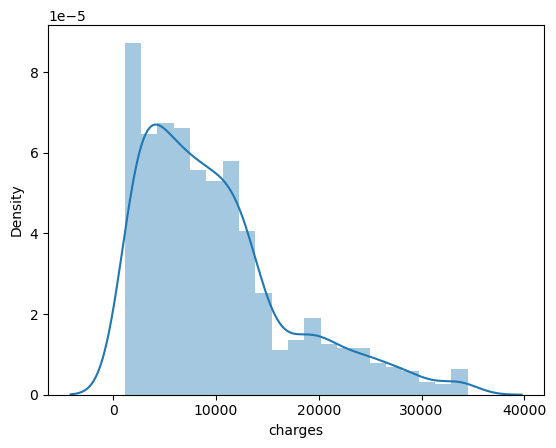

In [35]:
#comprobamos la distribucioon de nuestros datos
sns.distplot(df["charges"]);

No se parece a una camapa de Gauss, no tienen una distribución normal.

In [36]:
#comprobamos tambien con el metodo spahiro sobre la variable predictora
stats.shapiro(df["charges"])

ShapiroResult(statistic=0.8944879770278931, pvalue=7.002764574262084e-28)

El p-valor es menor a 0.05 rachazamos nuestra H0, no son datos normales.
Como no tiene una distribución normal, vamos a aplicar diferentes métodos para normalizar.

Vamos a probar con diferentes métodos a ver cual ajusta mejor:

### Stats.boxcox

In [37]:
df['charges_box'], lambda_ajustada = stats.boxcox(df['charges']) #Lo aplicamos a nuestra variable respuesta

In [38]:
lambda_ajustada

0.1902286200479272

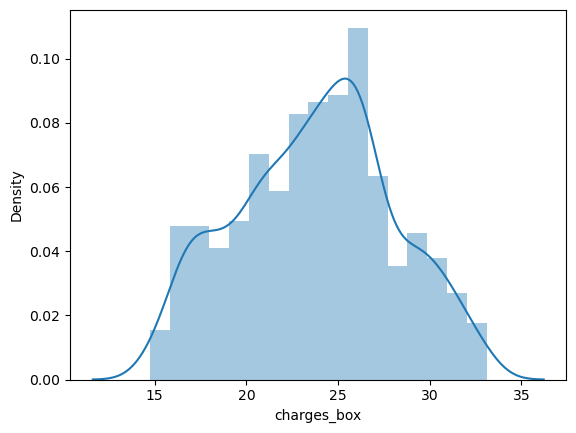

In [39]:
sns.distplot(df["charges_box"]); #chequeamos si tiene una distribución normal

In [40]:
stats.shapiro(df["charges_box"]) #Hacemos el Saphiro Test, que  nos dice que nuestros datos no son normales, al ser el pvalue menor que 0

ShapiroResult(statistic=0.9852656126022339, pvalue=1.1755207918184851e-09)

Este método no ha normalizado 'charges'

### Transformación logarítmica

In [41]:
#Aplicamos una list comprehension para evitar tener errores con los posibles valores 0 que tengamos en nuestra columna. 
df["charges_log"] = df["charges"].apply(lambda x: np.log(x) if x > 0 else 0)

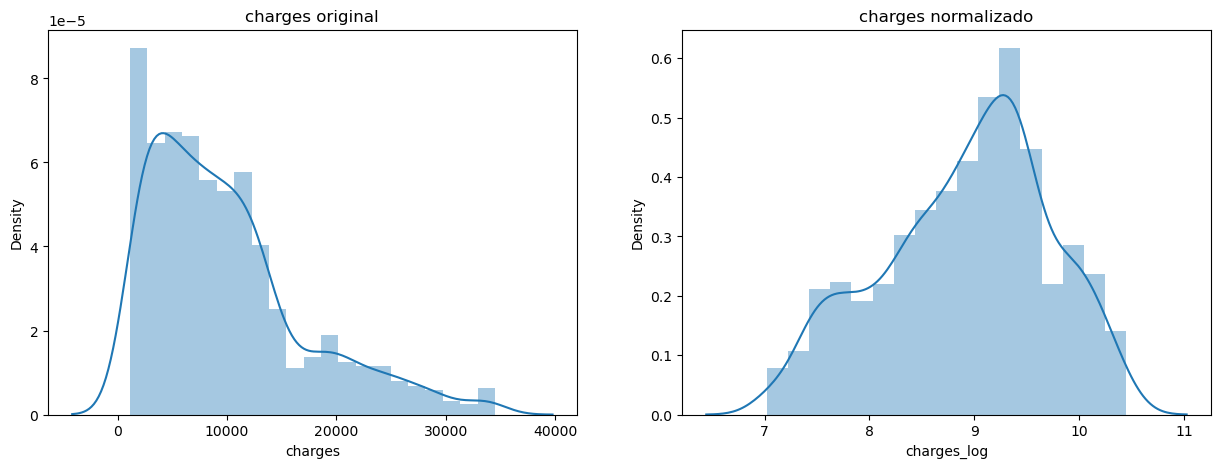

In [42]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('charges original')
axes[1].set_title('charges normalizado')

sns.distplot(df["charges"] ,ax = axes[0])
sns.distplot(df["charges_log"], ax = axes[1]);

In [43]:
stats.shapiro(df["charges_log"])

ShapiroResult(statistic=0.9769781231880188, pvalue=6.968173867777372e-13)

De nuevo nuestro p-valor es menor que 0.05, por lo que nuestros datos no son normales. Seguimos probando otras aproximaciones. 

## Raíz cuadrada

In [44]:
df["charges_raiz"] = df["charges"].apply(lambda x: math.sqrt(x))

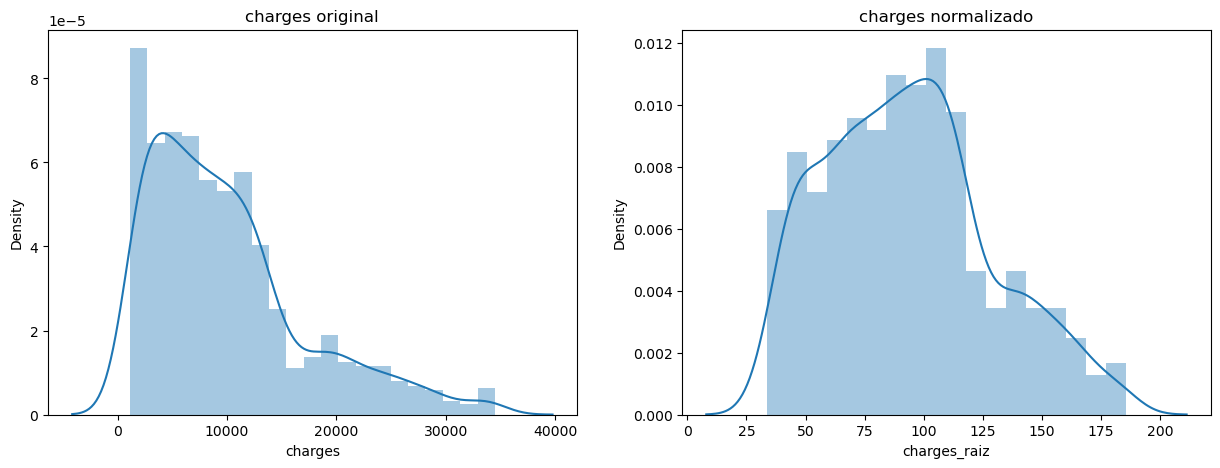

In [45]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('charges original')
axes[1].set_title('charges normalizado')

sns.distplot(df["charges"] ,ax = axes[0])
sns.distplot(df["charges_raiz"], ax = axes[1]);

In [46]:
stats.shapiro(df["charges_raiz"])

ShapiroResult(statistic=0.9718600511550903, pvalue=1.6568072868511363e-14)

Tampoco son normales.

### Sklearn MinMaxScaller

In [47]:
numericas = df.select_dtypes(include = np.number) #Extraemos las numéricas

In [48]:
# construimos el modelo de escalador
minmax = MinMaxScaler()

In [49]:
# ajustamos el modelo utilizando nuestro set de datos
minmax.fit(df[['charges']])

MinMaxScaler()

In [50]:
X_normalizadas = minmax.transform(df[["charges"]]) # transformamos los datos

In [51]:
# Vamos a verificar los valores mínimos después de la normalización
X_normalizadas.min(axis=0)

array([0.])

In [52]:
# y los máximos
X_normalizadas.max(axis=0)

array([1.])

In [53]:
# convertimos el array que nos devuelve en un dataframe. 

numericas_minmax = pd.DataFrame(X_normalizadas, columns = ["charges_Sklearn"])
numericas_minmax.head(2)

,charges_Sklearn
0,0.472641
1,0.018101


In [54]:
# incorporamos la columna al dataframe 

df["charges_Sklearn"] = numericas_minmax
df.head(2)

,age,sex,bmi,children,smoker,region,charges,charges_box,charges_log,charges_raiz,charges_Sklearn
0,19,female,27.90,0,yes,southwest,16884.9240,28.233192,9.734176,129.942002,0.472641
1,18,male,33.77,1,no,southeast,1725.5523,16.444206,7.453302,41.539768,0.018101


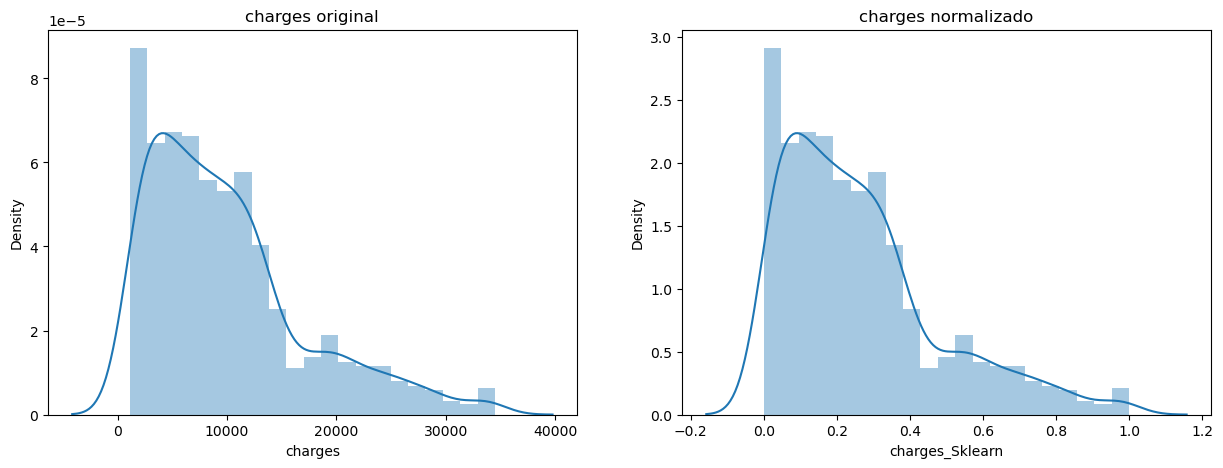

In [55]:
# ahora miramos si nuestra variable tiene una distribución normal

fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('charges original')
axes[1].set_title('charges normalizado')

sns.distplot(df['charges'] ,ax = axes[0])
sns.distplot(df['charges_Sklearn'], ax = axes[1]);

In [56]:
stats.shapiro(df["charges_Sklearn"])

ShapiroResult(statistic=0.8944879770278931, pvalue=7.002764574262084e-28)

El test de Saphiro nos da como pvalue < 0.05, no son normales.

**Pero ojo, hemos hecho algunas modificaciones en nuestro df por errores y antes el test de Saphiro nos daba como pvalue 1, que al ser mayor que 0.5 nos decía que no podíamos rechazar la H0 y nuestros datos no eran normales. Era la aproximación que mejor resultado nos daba, por lo que continuamos con esta columna en los siguientes pairs.**

**En realidad, el test  que mejor nos sale en este momento es el box cox, por lo que deberíamos haber continuado con ese.**

In [57]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'charges_box', 'charges_log', 'charges_raiz', 'charges_Sklearn'],
      dtype='object')

In [58]:
df.drop(['charges_box', 'charges_log', 'charges_raiz'], axis = 1, inplace = True)

In [59]:
df.to_csv('data/df_normalizado.csv')